# Convolutional Neural Networks for Handwritten Digits Recognition

This exercise will cover practical aspects for implementing convolutional neural networks (CNN) 

**Objectives**:

-  Using TensorFlow, you will build, from scratch, a CNN to classify handwritten digits.


# 1. Packages:
1.  [numpy](www.numpy.org) library used for numerical computing with Python.
2.  [matplotlib](www.matplotlib.org) to create graphs and show images in python.
3.  [Tensorflow](www.tensorflow.org) machine learning platform. This framework makes it easy to express high-level abstractions to build end-to-end deep neural networks (From data preparation to Model deployment)
4. [sklearn](https://scikit-learn.org) open source data analysis library, include machine learning algorithms for classification, clustering, regression...etc
5. [random]() is a Python module which is used to generate random numbers.

---



In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist#, fashion_mnist
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard

from sklearn.model_selection import train_test_split
from random import sample
import matplotlib.pyplot as plt

# 2.  MNIST Dataset

MNIST handwritten digits dataset already exist on TensorFlow. Load these images using load_data() function from mnist module, which return train and test sets (x_train, y_train), (x_test, y_test).

You have to display the properties of the dataset informations : 

1. Number of training and testing images
2. Number of classes
3. Image size


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Using the "train_test_split" sklearn function in order to split the train dataset into train/validation subsets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42 ,shuffle=True)

num_classes = len(set(y_train)) # indicate the number of classes

# Complete the following instructions

print("Number of train images", x_train.shape[0])
print("Number of val images", x_val.shape[0])
print("Number of test images", x_test.shape[0])
print("Number of classes", num_classes)
print("Image size", x_train.shape[1:3])

Number of train images 48000
Number of val images 12000
Number of test images 10000
Number of classes 10
Image size (28, 28)


#  Data visualization

Dispaly one image per class from the training or the testing datasets.

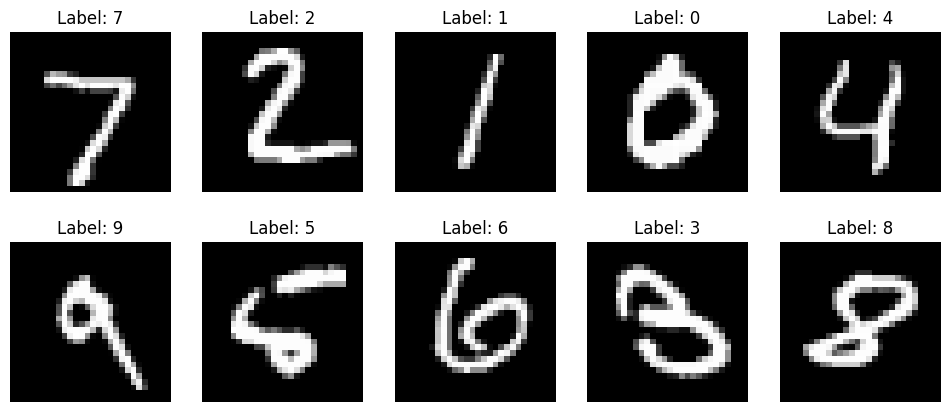

In [6]:
images = []
labels = []

for i, y in enumerate(y_test):
    if y in labels:
        continue
    
    labels.append(y)
    images.append(x_test[i])


fig = plt.figure(figsize = (12, 5))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, i+1)
    img = images[i]
    lbl = labels[i]
    ax.imshow(img, cmap='gray')         # ...
    ax.set_title("Label: " + str(lbl))  # Complete this code using matplotlib library...
    ax.axis('off')                      # ...

plt.show()

# Data Preprocessing

Images are represented in 8-bits integer in range [0-255]. 

The preprocessing you need to introduce is as follows:
*   Normalizing the pixel values range from [0-255] integer to [0-1] float
*   TensorFlow models support 3D image only as input. In our case, we have images with dimensions (H, W). Hence, we need to add a new dimension for each sample in order to have the grayscale one channel shape (H, W, 1) instead of (H, W). 
*   Make sure that the axis is added successfully by displaying the train and test shapes. It should have the following format : (NumOfImages, H, W, 1)



In [7]:
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0


x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_val = np.expand_dims(x_val, -1)

print("new train-set size:", x_train.shape)
print("new val-set size:", x_val.shape)
print("new test-set size:", x_test.shape)


new train-set size: (48000, 28, 28, 1)
new val-set size: (12000, 28, 28, 1)
new test-set size: (10000, 28, 28, 1)


# 3. Hyperparameters

In this cell, we set the hyperparameters:

- batch_size: is the number of samples processed before performing one update

- epochs: The number of training iteration

- Learning_rate: Control how fast we make updates on the weights during the training process

- l2_reg (L2 regularization): Is the L2 regularizer used for penalizing the output loss

In [9]:
batch_size = 128
epochs = 20
learning_rate = 0.1
l2_reg_rate = 0 # Replace L2 regularizer by a value > 0 for example 1e-4, otherwise it is disabled
dropout_rate = 0

# 4. Building the CNN model

LeNet-5 [1] architecture is defined below. It contains two Convloutional layers: 

- Convolutional_layer = (Conv2D-ReLU-MaxPool2D) x 2.

- The classification part contains two Dense layers and the output layer:

    - Dense layer = (Dense-ReLU)
    - Output layer = (Dense-Softmax)

**References**

[1]: Lecun Y, Bottou L, Bengio Y, et al. "Gradient-based learning applied to document recognition,". Proceedings of the IEEE, 1998, 86(11): 2278--2324

![Alt text](LeNet5.png)

In [10]:
def LeNet5(l2_reg, dropout):
    model = Sequential()
    model.add(InputLayer(input_shape = (28, 28, 1))) # you can use x_train.shape[1:] instead of (28, 28, 1)

    model.add(Conv2D(filters = 6, kernel_size = (5, 5), kernel_regularizer = l2(l2_reg)))
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Dropout(dropout))

    model.add(Conv2D(filters = 16, kernel_size = (5, 5), kernel_regularizer = l2(l2_reg)))
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(120, kernel_regularizer = l2(l2_reg)))
    model.add(Activation("relu"))

    model.add(Dropout(dropout))

    model.add(Dense(84, kernel_regularizer = l2(l2_reg)))
    model.add(Activation("relu"))

    model.add(Dropout(dropout))

    model.add(Dense(num_classes, kernel_regularizer = l2(l2_reg)))
    model.add(Activation("softmax"))
    
    return model

In [11]:
# LetNet5 model is built using the function LeNet5()
"""
dropout : Intialize the dropout rate for all the Dropout layers.
l2_reg : Initialize L2 regularizer for Conv2D layers and Dense layers.
"""
model = LeNet5(dropout=dropout_rate, l2_reg=l2_reg_rate)

# model.summary() will display a summary for your model (layers name, number of parameters...) to make
# sure you have created the model you want. 
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 activation (Activation)     (None, 24, 24, 6)         0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 6)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 activation_1 (Activation)   (None, 8, 8, 16)          0         
                                                      

# Optimizer and loss function

In the following cell, we: 
- define the loss function for our Model which is the Crossentropy function.
- initialize the Gradient Descent Optimizer "SGD".
- configure the model before training. We use for that "model.compile(...)"

Here, metrics allows to define which is/are the function(s) used to evaluate the model performence during training and testing (accuracy, IoU, loss, ...). For example: metrics = ["accuracy"]

In [12]:
loss = "SparseCategoricalCrossentropy"

opt = SGD(learning_rate=learning_rate)

model.compile(optimizer=opt, loss = loss, metrics = ["accuracy"])

# Model training

Now that our model is ready, we can start learning using the function "model.fit".

First, we have to shuffle our training data (shuffle = True).

You can notice that the performance change at the end of each epoch (train loss, train Accuracy, val loss, val accuracy)

=> Analyze the parameters of the function "model.fit". The output of this funtion is deeply analyzed in the next cell.

In [13]:
h = model.fit(x_train, y_train, epochs = epochs, batch_size=batch_size, validation_data = (x_val, y_val), shuffle = True)

Epoch 1/20


375/375 [==============================] - 3s 7ms/step - loss: 0.4192 - accuracy: 0.8652 - val_loss: 0.1213 - val_accuracy: 0.9637
Epoch 2/20
375/375 [==============================] - 2s 6ms/step - loss: 0.1028 - accuracy: 0.9682 - val_loss: 0.0878 - val_accuracy: 0.9736
Epoch 3/20
375/375 [==============================] - 2s 6ms/step - loss: 0.0756 - accuracy: 0.9761 - val_loss: 0.0764 - val_accuracy: 0.9766
Epoch 4/20
375/375 [==============================] - 2s 6ms/step - loss: 0.0624 - accuracy: 0.9800 - val_loss: 0.0627 - val_accuracy: 0.9808
Epoch 5/20
375/375 [==============================] - 2s 6ms/step - loss: 0.0511 - accuracy: 0.9844 - val_loss: 0.0627 - val_accuracy: 0.9796
Epoch 6/20
375/375 [==============================] - 2s 6ms/step - loss: 0.0435 - accuracy: 0.9864 - val_loss: 0.0609 - val_accuracy: 0.9821
Epoch 7/20
375/375 [==============================] - 2s 6ms/step - loss: 0.0383 - accuracy: 0.9879 - val_loss: 0.0563 - val_accuracy: 0.9823
Epoc

# 5. Display the Training & Validation plots

Let's analyze the logs of training.

Here, we plot train and validation accuracy during traning.

We also plot the loss w.r.t. epochs.

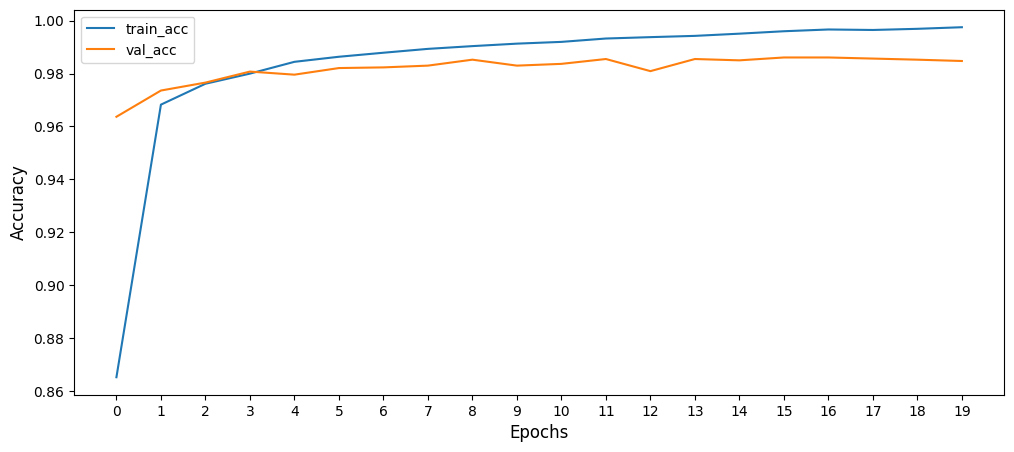

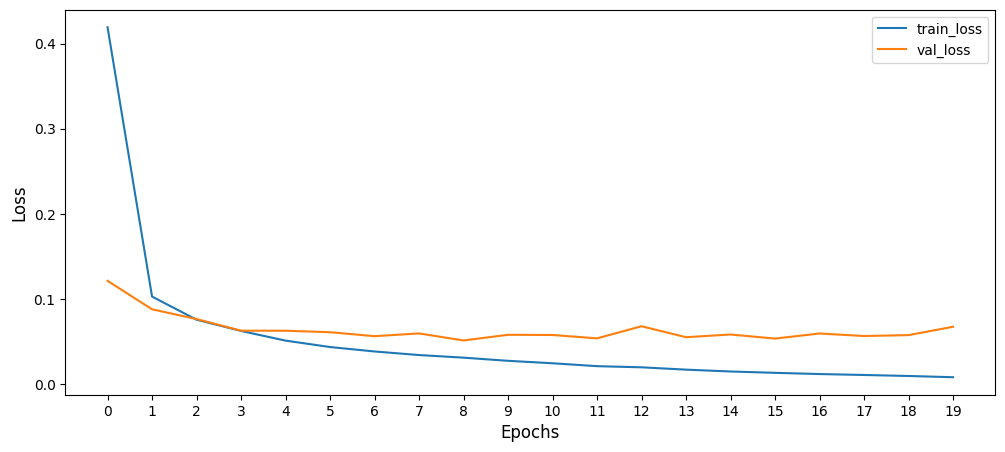

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(h.history["accuracy"], label = "train_acc")
plt.plot(h.history["val_accuracy"], label = "val_acc")
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.xticks(range(epochs))
plt.legend()

plt.figure(figsize=(12, 5))
plt.plot(h.history["loss"], label = "train_loss")
plt.plot(h.history["val_loss"], label = "val_loss")
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.xticks(range(epochs))
plt.legend()

plt.show()

# Evaluation on the test set

The funtion "model.evaluate" can be used to evaluate the performance of the model on the testset.

In [15]:
print("Model evaluation...")
loss, accuracy = model.evaluate(x_test, y_test)

Model evaluation...
313/313 [==============================] - 1s 2ms/step - loss: 0.0507 - accuracy: 0.9867


# Trained Model Evaluation:


Display few outputs of the trained model by randomly sampling images from x_test. If the prediction is not correct it will be highlited in different color (red)


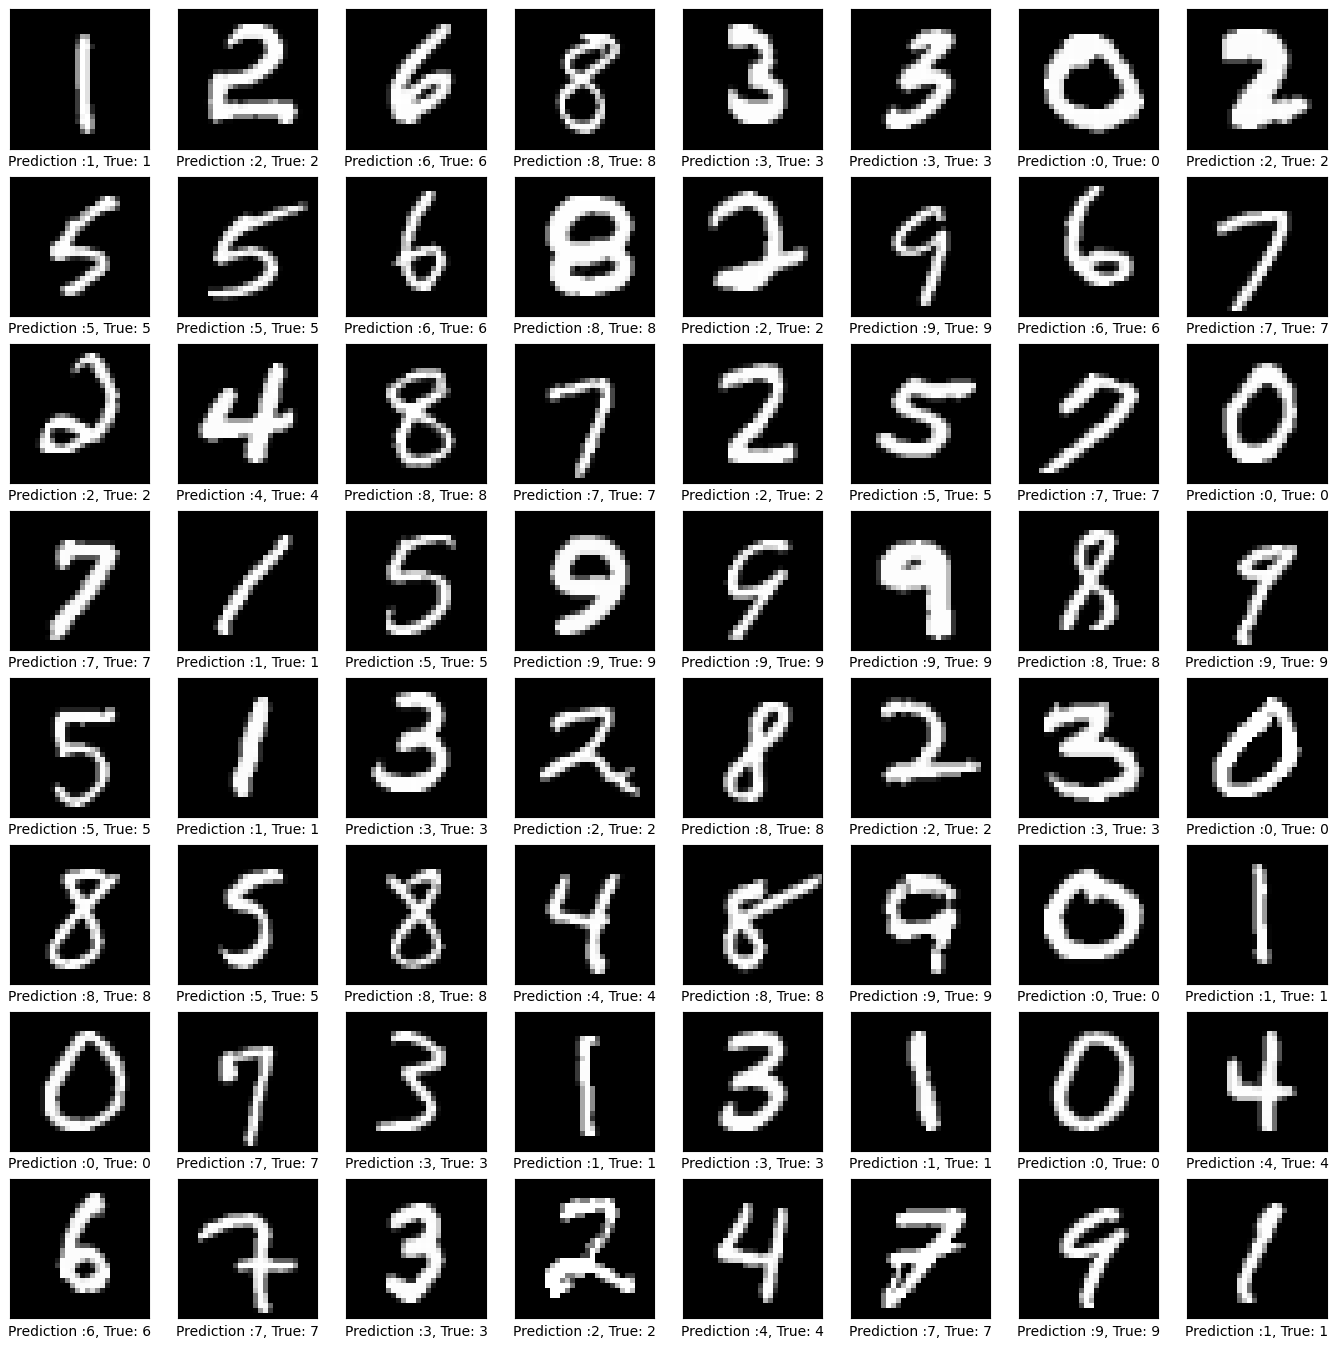

In [16]:
display = 64 #choose squares number [9, 16, 25, 36 ...]
samples = sample(range(10000), display) 

sampled_images = x_test[samples]  #sampling 25 random images from the test-set
sampled_labels = y_test[samples]  #sampling their corresponding labels

fig_train = plt.figure(figsize = (17, 17))

rows = int(display**0.5)
cols = int(display**0.5)
for i, (img, y_true) in enumerate(zip(sampled_images, sampled_labels)):
  
    ax = fig_train.add_subplot(rows, cols, i + 1)

    y_pred = model(np.expand_dims(img, 0), training = False)
    y_pred = np.argmax(y_pred)
    if y_pred == y_true:
      ax.set_xlabel("Prediction :{}, True: {}".format(y_pred, y_true), fontsize = 10, color = "k")
    else:
      ax.set_xlabel("Prediction :{}, True: {}".format(y_pred, y_true), fontsize = 10, color = "r")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.squeeze(), cmap = 'gray')

plt.show()

# Learning rate decay functions 

The following functions correspond to different learning rate scheduler:

1. step_decay : step-based learning rate decay. The initial learning rate is divided after performing several epochs.
2. exo_decay : exponential-based learning rate decay. The learning rate value will follow the expontial form starting from the initial value.


Example of different Schedulers :


![Alt text](lr_scheduler.png)

In [17]:
#Step decay
def step_decay(epoch):

    lr = learning_rate
    if epoch >= 24:
        lr = lr * lr_decay**3
    elif epoch >= 16:
        lr = lr * lr_decay**2
    elif epoch >= 8:
        lr = lr * lr_decay**1

    return lr

#Exponential decay
def exp_decay(epoch):

    lr = learning_rate * np.exp(-lr_decay * epoch)

    return lr

# To do: Provide a description of the code and the dataset

### ...

# 6. Grid Search

In the cell below, you will be able to train multiple models, each one with a specific configuration of hyperparameters and functions.

Notice that this process will take few ~Hours depending on the performence of your machine and the total number of combinations.

You can add or change the parameters directly from the for loops.

Using the following config, the total number of combinations is 32.

Feel free to modify or add other hyperparameters to see the impact on the model performence

In [18]:
history = []

for batch_size in [128, 1024]: #you can try 8, 32...
    for epochs in [30]:
        for learning_rate in [1e-3]:
            for l2_reg in [0, 5e-4]:
                for dropout in [0, 0.4]:
                    for lr_decay in [0.1]: #you can also try 0.01, 0.1, 0.2...
                        for decay_function in [step_decay, exp_decay]:
                            for opt in [Adam(learning_rate=learning_rate), RMSprop(learning_rate=learning_rate)]: #SGD(learning_rate = learning_rate)
                                
                                model_name = "LeNet5-bs{}-ep{}-lr{}-l2reg{}-do{}-lrdec{}-{}-{}".format(batch_size, epochs, learning_rate, l2_reg, dropout, lr_decay,
                                                                                                            "step_decay" if decay_function is step_decay else "exp_decay",
                                                                                                            "Adam" if isinstance(opt, Adam) else "RMSProp" if isinstance(opt, RMSprop) else "SGD")
                                model = LeNet5(l2_reg, dropout)

                                loss = "SparseCategoricalCrossentropy"
                                model.compile(optimizer = opt, loss = loss, metrics = ["accuracy"])

                                lr_scheduler = LearningRateScheduler(decay_function, verbose=0)
                                checkpoint = ModelCheckpoint(filepath="./saved_models/{}.hdf5".format(model_name), save_best_only=True, monitor="val_accuracy", verbose=0)
                                tensorboard = TensorBoard("./logdir/{}".format(model_name))
                                callbacks = [lr_scheduler, checkpoint, tensorboard]
                                
                                print("Start Training for {} epochs".format(epochs))
                                h = model.fit(x_train, y_train, epochs = epochs, batch_size=batch_size, validation_data = (x_val, y_val), shuffle = True, callbacks = callbacks, verbose = 0)
                                history.append(h)
                                print("End of training", model_name)
                                print("Evaluation of the best checkpoint...")
                                model = load_model("./saved_models/{}.hdf5".format(model_name))
                                loss, accuracy = model.evaluate(x_test, y_test)
                                print("\n")

Start Training for 30 epochs


c:\Users\37718890.INTRANET\Desktop\GitHub\S9_el_tegy_samuel_ladibe\Modelisation\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


End of training LeNet5-bs128-ep30-lr0.001-l2reg0-do0-lrdec0.1-step_decay-Adam
Evaluation of the best checkpoint...
313/313 [==============================] - 1s 2ms/step - loss: 0.0324 - accuracy: 0.9899


Start Training for 30 epochs
End of training LeNet5-bs128-ep30-lr0.001-l2reg0-do0-lrdec0.1-step_decay-RMSProp
Evaluation of the best checkpoint...
313/313 [==============================] - 1s 2ms/step - loss: 0.0360 - accuracy: 0.9904


Start Training for 30 epochs
End of training LeNet5-bs128-ep30-lr0.001-l2reg0-do0-lrdec0.1-exp_decay-Adam
Evaluation of the best checkpoint...
313/313 [==============================] - 1s 2ms/step - loss: 0.0368 - accuracy: 0.9897


Start Training for 30 epochs
End of training LeNet5-bs128-ep30-lr0.001-l2reg0-do0-lrdec0.1-exp_decay-RMSProp
Evaluation of the best checkpoint...
313/313 [==============================] - 1s 2ms/step - loss: 0.0357 - accuracy: 0.9905


Start Training for 30 epochs
End of training LeNet5-bs128-ep30-lr0.001-l2reg0-do0.4-l

# Which model is the best? Visualizing metrics with TensorBoard:

For better visualization, you need to open the training plots using tensorboard as following: 


- Make sure that tensorboard is already installed in your machine, otherwise run the following command : pip install tensorboard


1. Open the Command Prompt CMD on the current directory
2. Run the command : tensorboard --logdir ./logdir
3. Wait few seconds... Then copy the given adress (http://localhost:XXXX/)
4. Open your browser (Google Chrome) and past the adress on the adress bar
5. Take a look on the different plots, each one has the name of the corresponding model
6. Comment the results


- For those who use colab, run the following commands on the notebook cells :

1. %load_ext tensorboard
2. %tensorboard --logdir directory/to/logs

Notes:

1. You can download the logs on your pc instead of opening TensorBoard on colab
2. You can open tensorboard monitor during the training without waiting until the end of process (Refresh your browser to update the plots) 

# Add more options in the grid search in order to further improve the result

In [ ]:
### ...